In [1]:
from task2vec import Task2Vec
from models import get_model
import datasets
import task_similarity
import argparse
import torch
import torch.nn.functional as F
import torchvision.transforms as tt
import torch.nn as nn
from tqdm import tqdm
from synbols_utils import Synbols
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

seed = 123


In [2]:
def data_pipeline(selected_languages, selected_attrs, filter = True):

    def select(data, langs, attrs):
        select = data[(data['lang'].isin(langs)) & (data['attr'].isin(attrs))]
        return select
    def merge(saved, ref):
        data = pd.DataFrame(saved)
        data['lang'] = ref['lang']
        data['attr'] = ref['attr']
        data['name'] = ref['name']
        return data


    saved = torch.load('all.pt')
    seed = 123
    ref = pd.read_csv('ref.csv', index_col = 0)
    data = merge(saved, ref)
    if filter:
        data = select(data=data, langs = selected_languages, attrs = selected_attrs)
    Z = [x.hessian for x in data[0].to_numpy()]
    return Z, data.reset_index(drop=True)

In [3]:

# Add Task2Vec as part of the SingleHead Class

class AttentionNet(nn.Module):
    """Soft-Attention on the Embedding z"""
    
    def __init__(self, input_dim, latent_dim):
        super(Attention, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.attention = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(inplace=True), #FIXME Try Tanh as well
            nn.Linear(latent_dim,input_dim)
        )

    def forward(self, x):
        x = self.attention(x)
        return F.softmax(x)


class AttentionRawList(nn.Module):
    """Attention through Raw Params
            Input: Param shape, No of Params"""
    def __init__(self, shape, N):
        super(AttentionRaw, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn((shape))) for _ in range(N)])

    def __getitem__(self, index):
        return self.params[index]

    def forward(self, index, x):
        # Weighted/Atttention on x using Attention 'i'
        return self.params[index] * x 

class AttentionRaw(nn.Module):
    """Attention through Raw Params
            Input: Param shape, No of Params"""
    def __init__(self, shape):
        super(AttentionRaw, self).__init__()
        # Attention Params: Shape N_attn, M as N Attentions of dimension M 
        self.params = nn.Parameter(torch.randn(N, task2vec_dim), requires_grad = True)

    def forward(self, x):
        # Weighted/Atttention on x using Attention 'i'
        # X shape: N_z, M, Params shape: N_attn, M
        # Do Element wise multiplication
        soft = F.softmax(self.params, dim = -1)
        return torch.mul(torch.unsqueeze(soft, 1), x) 

Z = [z.hessian for z in saved]
task2vec_dim = Z[0].shape[0]
latent_dim = 128
M = len(Z) # No of Task vectors
Z_tensor = torch.tensor(Z)

In [4]:
def cos_sim(A,B, eps=1e-8, ):
    A_norm = A.norm(dim = -1, keepdim = True)
    B_norm = B.norm(dim = -1, keepdim = True)
    A_norm = torch.maximum(A_norm, eps * torch.ones(A_norm.shape))
    B_norm = torch.maximum(B_norm, eps * torch.ones(B_norm.shape))
    A = torch.div(A,A_norm)
    B = torch.div(B,B_norm)
    return torch.mm(A,B.T)
def norm_unitvectors(M, eps = 1e-8):
    M_norm = M.norm(dim = -1, keepdim = True)
    M_norm = torch.maximum(M_norm, eps * torch.ones(M_norm.shape))
    return torch.div(M, M_norm)
def positives(Attrs):
    M = norm_unitvectors(Attrs)
    M_trans = M.transpose(1,2)
    return torch.bmm(M, M_trans)
def positive_loss(Attrs, log = True):
    if log:
        x = -torch.log(positives(Attrs).flatten())
    else:
        x = 1 - positives(Attrs).flatten().to(torch.float16)
    return x.sum()
def negative_loss(Attrs):
    """For two attributes
    """
    neg_pair = cos_sim(Attrs[0], Attrs[1])
    return (neg_pair.flatten()).sum()

(1 - cos_sim(attr_pos, attr_pos).flatten().to(torch.float16)).sum()

In [41]:
cos_sim(attrs[0],attrs[0])

torch.Size([12, 12])

In [98]:
def xent_loss_(pos, neg, temperature = 2):
    denom = torch.exp(neg/temperature)
    numer = torch.exp(pos/temperature)
    return - torch.log(numer/denom.sum())

tensor([4.8273, 4.8605, 4.8624, 4.8603, 4.8605, 4.8273, 4.8524, 4.8416, 4.8624,
        4.8524, 4.8273, 4.8536, 4.8603, 4.8416, 4.8536, 4.8273],
       grad_fn=<NegBackward>)

In [100]:
# FIXME Positive/Negative pairs selected only inter-attribute

attrs = attns(Z_tensor)
pos = {}
mas = {}
mapping = {}
loss = {}
total_loss = 0.0
i = 0
for attr in selected_attrs:
    mapping[i] = attr
    pos[attr] = data[data['attr'] == attr]['ix'].to_numpy()
    mask = torch.zeros(attrs[i].shape[0])
    mask[pos[attr]] = 1
    mask = mask.unsqueeze(-1)
    mask = (mask @ mask.T).bool()

    cos_matrix = cos_sim(attrs[i], attrs[i])
    pos = cos_matrix[mask]
    neg = cos_matrix[~mask]

    xent_loss = xent_loss_(pos,neg)
    loss[attr] = xent_loss.sum().detach().numpy()
    total_loss += xent_loss.sum()

TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

In [23]:
attr_pos.shape

torch.Size([4, 13824])

In [19]:
attr_neg

tensor([[1.6400e-08, 2.0031e-09, 7.4741e-09,  ..., 2.7018e-10, 1.8837e-10,
         5.2031e-11],
        [1.8674e-08, 4.0263e-09, 1.2031e-08,  ..., 3.3624e-10, 1.7096e-10,
         9.7023e-11],
        [1.5342e-08, 2.3924e-09, 6.3507e-09,  ..., 3.8190e-10, 1.6085e-10,
         8.1987e-11],
        [2.1477e-08, 4.2319e-09, 1.1849e-08,  ..., 4.1318e-10, 1.9511e-10,
         6.0749e-11]], grad_fn=<IndexSelectBackward>)

torch.Size([4, 13824])

pos.keys()

attr_pos = torch.index_select(attrs[0],0, torch.tensor(pos['gradient']))

pos

attrs = attns(Z_tensor)

attrs[0].shape

In [6]:
def train_supervised(attns, Z, optimizer):
    attns.train()
    attrs = attns(Z)
    total_loss, loss, mapping, loss_negative = supervised_loss(data=data,attrs=attrs,selected_attrs=selected_attrs)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return total_loss, loss, mapping, loss_negative

def train(attns, Z, optimizer, gamma = 2):
    attns.train()
    attrs = attns(Z)
    pos_loss = positive_loss(attrs)
    neg_loss = negative_loss(attrs)
    loss =  pos_loss + neg_loss * gamma
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return pos_loss, neg_loss, loss

In [7]:
filter = True
selected_languages =   ['tamil','malayalam', 'japanese','chinese'] #['arabic', 'bangla', 'greek', 'english', 'gujarati', 'hebrew', 'japanese', 'khmer', 'malayalam', 'russian', 'tamil', 'telugu', 'thai', 'vietnamese', 'chinese'] #['malayalam', 'chinese', 'tamil']
filter_attrs = ['gradient', 'rotated', 'std'] # 'scaled',
selected_attrs = ['gradient', 'rotated'] # 'scaled',
Z, data = data_pipeline(selected_languages, filter_attrs, filter = filter)
Z_tensor = torch.tensor(Z)
task2vec_dim = Z_tensor.shape[1]
M = Z_tensor.shape[0] # No of Task vectors
latent_dim = 128

In [8]:
data['ix'] = data.index.to_list()
pos_std = data[data['attr'] == 'std']['ix'].to_numpy()

In [9]:
N = 2 # No of attributes
attns = AttentionRaw((N, task2vec_dim)) #AttentionRawList(task2vec_dim, N)

In [18]:
n_epochs = 500
gamma = 1.
optimizer = torch.optim.Adam(attns.parameters(), lr = 1e-2)
for epoch in range(n_epochs):
    total_loss, loss, mapping, neg_losses = train_supervised(attns, Z_tensor, optimizer)
    if epoch%100 == 0:
        print(f"Epoch: {epoch}, total_loss: {total_loss}, pos_losses: {loss}, neg_loss:{neg_losses}")

Epoch: 0, total_loss: 31.625, pos_losses: {'gradient': array(0.4707, dtype=float16), 'rotated': array(0.787, dtype=float16)}, neg_loss:{'gradient': array(15.22, dtype=float16), 'rotated': array(15.15, dtype=float16)}
Epoch: 100, total_loss: 29.8125, pos_losses: {'gradient': array(0.4727, dtype=float16), 'rotated': array(0.536, dtype=float16)}, neg_loss:{'gradient': array(14.48, dtype=float16), 'rotated': array(14.32, dtype=float16)}
Epoch: 200, total_loss: 27.25, pos_losses: {'gradient': array(0.456, dtype=float16), 'rotated': array(0.3965, dtype=float16)}, neg_loss:{'gradient': array(13.164, dtype=float16), 'rotated': array(13.24, dtype=float16)}
Epoch: 300, total_loss: 22.53125, pos_losses: {'gradient': array(0.372, dtype=float16), 'rotated': array(0.3594, dtype=float16)}, neg_loss:{'gradient': array(10.44, dtype=float16), 'rotated': array(11.37, dtype=float16)}
Epoch: 400, total_loss: 21.6875, pos_losses: {'gradient': array(0.9805, dtype=float16), 'rotated': array(0.758, dtype=float

In [58]:
attrs = attns(Z_tensor)
task_attributes = attrs.transpose(0,1)
task_attribute_magnitudes = task_attributes.norm(dim = -1)
final = pd.DataFrame(task_attribute_magnitudes.detach().numpy(), columns = ['x','y'])
data['x'] = final['x']
data['y'] = final['y']

In [59]:
task_attributes.shape

torch.Size([12, 2, 13824])

In [60]:
attrs.shape

torch.Size([2, 12, 13824])

In [61]:
attrs[0].shape

torch.Size([12, 13824])

In [62]:
cos_sim(attrs[0], attrs[1])

tensor([[0.0074, 0.0072, 0.0073, 0.0083, 0.0085, 0.0079, 0.0085, 0.0078, 0.0089,
         0.0092, 0.0111, 0.0089],
        [0.0076, 0.0075, 0.0076, 0.0085, 0.0087, 0.0081, 0.0087, 0.0080, 0.0091,
         0.0095, 0.0113, 0.0091],
        [0.0074, 0.0072, 0.0074, 0.0083, 0.0086, 0.0079, 0.0085, 0.0078, 0.0089,
         0.0093, 0.0111, 0.0089],
        [0.0072, 0.0071, 0.0072, 0.0082, 0.0084, 0.0077, 0.0084, 0.0077, 0.0088,
         0.0091, 0.0110, 0.0088],
        [0.0069, 0.0067, 0.0069, 0.0078, 0.0082, 0.0075, 0.0081, 0.0074, 0.0085,
         0.0089, 0.0107, 0.0085],
        [0.0071, 0.0069, 0.0071, 0.0080, 0.0083, 0.0077, 0.0083, 0.0076, 0.0087,
         0.0091, 0.0109, 0.0087],
        [0.0070, 0.0068, 0.0069, 0.0079, 0.0082, 0.0075, 0.0082, 0.0075, 0.0085,
         0.0089, 0.0107, 0.0086],
        [0.0071, 0.0069, 0.0071, 0.0080, 0.0083, 0.0077, 0.0083, 0.0076, 0.0087,
         0.0090, 0.0109, 0.0087],
        [0.0070, 0.0067, 0.0069, 0.0079, 0.0082, 0.0075, 0.0081, 0.0074, 0.0086,

In [63]:
cos_sim(attrs[0], attrs[1]).shape

torch.Size([12, 12])

In [64]:
attns.params.shape

torch.Size([2, 13824])

In [65]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = PCA(n_components=2, random_state=seed)
X_2d = tsne.fit_transform(final)


In [66]:
data

,0,lang,attr,name,ix,x,y
0,<task2vec.Embedding object at 0x7f1370ecb490>,chinese,gradient,chinese_gradient.h5py,0,0.000004,0.000030
1,<task2vec.Embedding object at 0x7f1370ecbe10>,malayalam,gradient,malayalam_gradient.h5py,1,0.000004,0.000036
2,<task2vec.Embedding object at 0x7f1370ecb1d0>,japanese,gradient,japanese_gradient.h5py,2,0.000004,0.000030
3,<task2vec.Embedding object at 0x7f1370ed6f90>,tamil,gradient,tamil_gradient.h5py,3,0.000005,0.000036
4,<task2vec.Embedding object at 0x7f1370f6e5d0>,chinese,rotated,chinese_rotated.h5py,4,0.000007,0.000045
5,<task2vec.Embedding object at 0x7f1370f3ac90>,malayalam,rotated,malayalam_rotated.h5py,5,0.000006,0.000044
6,<task2vec.Embedding object at 0x7f1370f3a8d0>,japanese,rotated,japanese_rotated.h5py,6,0.000007,0.000047
7,<task2vec.Embedding object at 0x7f1370f3a110>,tamil,rotated,tamil_rotated.h5py,7,0.000005,0.000038
8,<task2vec.Embedding object at 0x7f1370fb4f90>,malayalam,std,malayalam.h5py,8,0.000005,0.000030
9,<task2vec.Embedding object at 0x7f1370fb4710>,chinese,std,chinese.h5py,9,0.000008,0.000043


sns.catplot(x="x", y="y", hue="attr",
            col="lang", aspect=.7, data = data)
            #kind="swarm", data=data)

In [67]:
sns.set(rc={'figure.figsize':(15,15)})


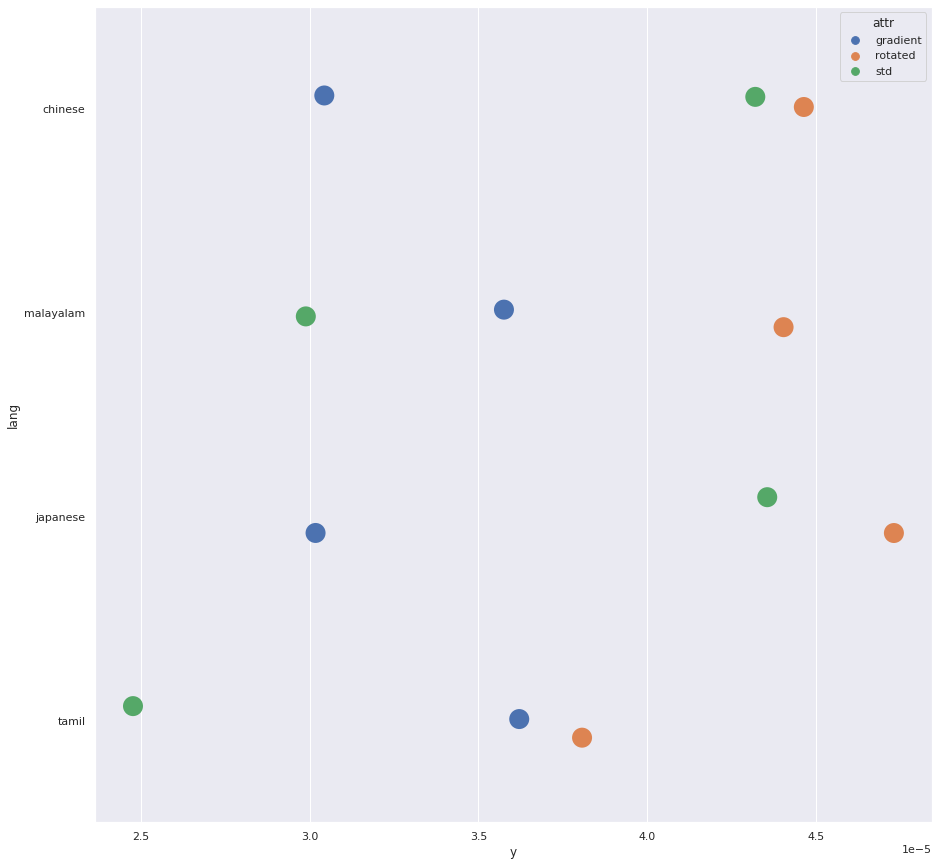

In [68]:
ax = sns.stripplot(x="y", y="lang", hue = "attr", data=data, s=20)

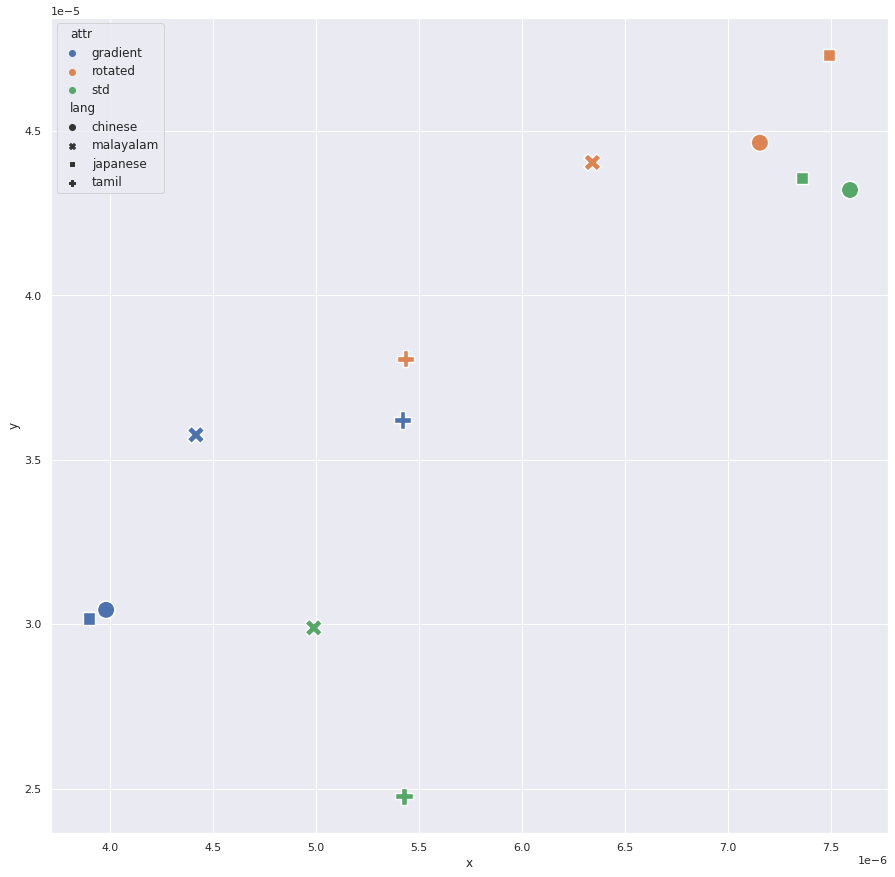

In [69]:
#plt.figure(figsize = (15,15))
sns.scatterplot(data=data, x="x", y="y", hue = "attr", style="lang", s = 300)

### Test on Unseen

In [70]:
all = ['arabic', 'bangla', 'greek', 'english', 'gujarati', 'hebrew', 'japanese', 'khmer', 'malayalam', 'russian', 'tamil', 'telugu', 'thai', 'vietnamese', 'chinese']


In [72]:
filter = True
test_selected_languages =   list(set(all) - set(selected_languages)) #['arabic', 'bangla', 'greek', 'english', 'gujarati', 'hebrew', 'japanese', 'khmer', 'malayalam', 'russian', 'tamil', 'telugu', 'thai', 'vietnamese', 'chinese'] #['malayalam', 'chinese', 'tamil']
test_selected_attrs = filter_attrs #['gradient', 'rotated'] # 'scaled',
Z_test, data_test = data_pipeline(test_selected_languages, test_selected_attrs, filter = filter)
Z_tensor_test = torch.tensor(Z_test)

In [73]:
data_test

,0,lang,attr,name
0,<task2vec.Embedding object at 0x7f1371103f50>,english,rotated,english_rotated.h5py
1,<task2vec.Embedding object at 0x7f13711034d0>,arabic,rotated,arabic_rotated.h5py
2,<task2vec.Embedding object at 0x7f1371103c10>,khmer,gradient,khmer_gradient.h5py
3,<task2vec.Embedding object at 0x7f1371103cd0>,gujarati,gradient,gujarati_gradient.h5py
4,<task2vec.Embedding object at 0x7f137103cad0>,greek,rotated,greek_rotated.h5py
5,<task2vec.Embedding object at 0x7f137103ce90>,thai,rotated,thai_rotated.h5py
6,<task2vec.Embedding object at 0x7f137103ce50>,telugu,rotated,telugu_rotated.h5py
7,<task2vec.Embedding object at 0x7f137103c7d0>,greek,std,greek.h5py
8,<task2vec.Embedding object at 0x7f137103c890>,vietnamese,gradient,vietnamese_gradient.h5py
9,<task2vec.Embedding object at 0x7f137103c9d0>,telugu,std,telugu.h5py


In [74]:
attns.eval()
attrs_test = attns(Z_tensor_test)
task_attributes_test = attrs_test.transpose(0,1)
task_attribute_magnitudes_test = task_attributes_test.norm(dim = -1)
test_final = pd.DataFrame(task_attribute_magnitudes_test.detach().numpy(), columns = ['x','y'])
data_test['x'] = test_final['x']
data_test['y'] = test_final['y']

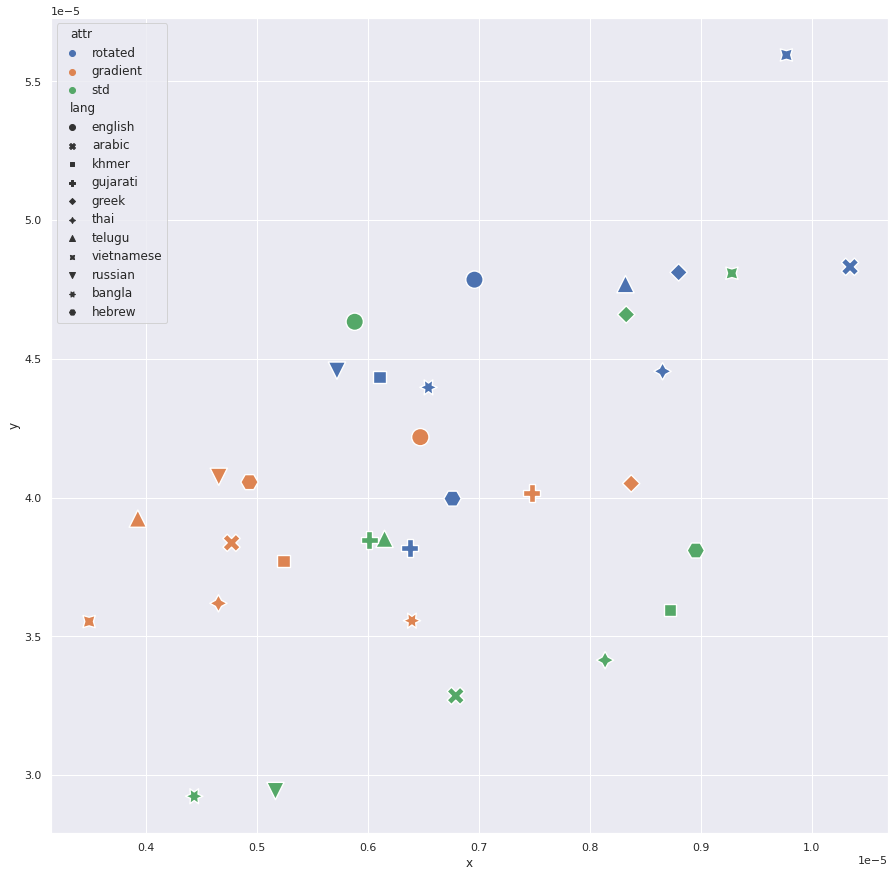

In [75]:
#plt.figure(figsize = (15,15))
sns.scatterplot(data=data_test, x="x", y="y", hue = "attr", style="lang", s = 300)

In [143]:
#Attentions.cuda()
Z_loader = torch.utils.data.DataLoader(Z, batch_size = len(Z))
optimizer = torch.optim.Adam(attns.parameters())

attns_z_matrix = attns(Z_tensor)

import numpy as np
attns_query = torch.mm(attns.params, Z_tensor.T) / np.sqrt(1384)

batch_size = 1024
q_len = 32
v_len = 32
hidden_dim = 128
k_len = 32
query = torch.randn((batch_size, q_len, hidden_dim)) # q_len, hidden_dim @ hidden_dim, k_len 
key = torch.randn((batch_size, k_len, hidden_dim))
value = torch.randn((batch_size, v_len, hidden_dim))

score = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(hidden_dim)
attn = F.softmax(score, -1)
context = torch.bmm(attn, value)

In [63]:
for _, batch in enumerate(Z_loader):
    break

In [64]:
attrs = attns(batch)


def _similarity_matrix(attrs, epsilon = 1e-8):
    norm = attrs.norm(dim = -1, keepdim = True)
    norm = torch.maximum(norm, 1e-8 * torch.ones(norm.shape))
    attrs = attrs / norm
    temp = attrs.view(attrs.shape[0], attrs.shape[1],1,1,attrs.shape[2])
    similarity_matrix = torch.mul(temp,attrs).sum(axis = -1)
    return similarity_matrix

similarity_matrix = _similarity_matrix(attrs)

## Sample 

In [110]:
Attns = [[0.5, 0.5], [0.2, 0.8], [0.1, 0.9]] # Three Attns 3x2
Z = [[1,2],[3,4],[5,6],[7,8],[9,10]] # 5 z vectors. 5 x 2
Attns = torch.tensor(Attns)
Z = torch.tensor(Z)
print(f"Attns: {Attns.shape}, Z: {Z.shape}")

Attns: torch.Size([3, 2]), Z: torch.Size([5, 2])


In [111]:
def forward_pass(Attns, Z):
    return torch.mul(torch.unsqueeze(Attns, 1), Z) 

In [112]:
Attrs = forward_pass(Attns, Z)
Attrs.shape

torch.Size([3, 5, 2])

In [9]:
def cos_sim(A,B, eps=1e-8, ):
    A_norm = A.norm(dim = -1, keepdim = True)
    B_norm = B.norm(dim = -1, keepdim = True)
    A_norm = torch.maximum(A_norm, eps * torch.ones(A_norm.shape))
    B_norm = torch.maximum(B_norm, eps * torch.ones(B_norm.shape))
    A = torch.div(A,A_norm)
    B = torch.div(B,B_norm)
    return torch.mm(A,B.T)
cos_sim(Attrs[0],Attrs[0]).flatten().contiguous()

tensor([1.0000, 0.9839, 0.9734, 0.9676, 0.9640, 0.9839, 1.0000, 0.9987, 0.9972,
        0.9960, 0.9734, 0.9987, 1.0000, 0.9997, 0.9993, 0.9676, 0.9972, 0.9997,
        1.0000, 0.9999, 0.9640, 0.9960, 0.9993, 0.9999, 1.0000])

In [ ]:
def all(attrs):
    return torch.matmul(attrs.unsqueeze(-1).transpose(2,3), attrs.unsqueeze(-1)).squeeze()

In [118]:
Attrs.unsqueeze(-1).transpose(2,3).shape

torch.Size([3, 5, 1, 2])

In [116]:
Attrs.unsqueeze(-1).shape

torch.Size([3, 5, 2, 1])

In [114]:
Attrs

tensor([[[0.5000, 1.0000],
         [1.5000, 2.0000],
         [2.5000, 3.0000],
         [3.5000, 4.0000],
         [4.5000, 5.0000]],

        [[0.2000, 1.6000],
         [0.6000, 3.2000],
         [1.0000, 4.8000],
         [1.4000, 6.4000],
         [1.8000, 8.0000]],

        [[0.1000, 1.8000],
         [0.3000, 3.6000],
         [0.5000, 5.4000],
         [0.7000, 7.2000],
         [0.9000, 9.0000]]])

In [52]:
positive_loss()

In [79]:
orthogonality_loss =  

In [45]:
# Positives
# sim(Attr[i], Attr[j]) = 1 | -1 
# |sim(Attr[i], Attr[j])| = 1
# for all i, and i = j

# Negatives or Zero
#   Negatives:
#       sim(Attr[i], Attr[j]) for all i=/j

# or induce Orthogonality as   Zero:
#   sim(Attr[i], Attr[j]) = 0



def positives(Attrs):
    """
    """
    

tensor([0.9430, 0.9615, 0.9668, 0.9693, 0.9708, 0.8682, 0.8969, 0.9056, 0.9097,
        0.9122, 0.8417, 0.8730, 0.8826, 0.8873, 0.8900, 0.8284, 0.8610, 0.8711,
        0.8759, 0.8788, 0.8205, 0.8538, 0.8641, 0.8691, 0.8720])

In [59]:
cos_matrix = _similarity_matrix(Attrs)
cos_matrix.shape

torch.Size([3, 5, 3, 5])

In [64]:
cos_matrix[0][:][0][:]

tensor([[1.0000, 0.9839, 0.9734, 0.9676, 0.9640],
        [0.9430, 0.9615, 0.9668, 0.9693, 0.9708],
        [0.9179, 0.9285, 0.9318, 0.9335, 0.9345]])

In [25]:
i = 0
j = 6
k = 6
similarity_matrix[i][:][i][:].shape

torch.Size([4, 135])

In [ ]:
def positives(sim_matrix, i):
    """
        For all j,k: do summation of cos similarities across matrix for given i
        
        Note: mat[i][j][i][k] represents sim(att[i][j], att[i][k])
        So, for i'th attribute, positives are:
            SUM_j,k mat[i][j][i][k]
    """

In [ ]:
def alignment_loss(similarity_matrix):
    

In [ ]:
for epoch in range(n_epochs):
    print(f"Epoch:{epoch}")
    attentions.train()
    for batch_ix, Z in enumerate(Z_loader):
        optimizer.zero_grad()
        

In [ ]:

for epoch in range(args.epochs):
    print("Epoch", epoch)
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

    print("train_loss", float(loss))
    with torch.no_grad():
        model.eval()
        hits = 0
        total = 0
        for batch in tqdm(val_loader):
            x, y = batch
            x = x.cuda()
            y = y.cuda()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            hits += (logits.argmax(-1) == y).float().sum().item()
            total += x.size(0)

    print("val_loss", float(loss), "val_accuracy", hits / total)
